In [9]:
from regvelovi import REGVELOVI

Global seed set to 0


In [10]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [11]:
scv.set_figure_params()

In [12]:
adata = sc.read_h5ad("dataset_branch_v4.h5ad")

In [13]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [14]:
adata.uns["skeleton"].shape

(210, 210)

In [15]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=260)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 29 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
adata.layers["Ms"].max()

36.889286

In [18]:
adata.X = np.log1p(adata.X.copy())

In [19]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 73
num targets: 117


In [20]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [21]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T)

In [22]:
#GRN = torch.tensor(np.log1p(grnboost_m)) * torch.ones(W.T.shape) * torch.sign(corr_m)
#GRN = GRN.float()
#GRN

In [23]:
reg_vae.module.v_encoder.grn.data = reg_vae.module.v_encoder.grn.data*6.5

In [189]:
#coef = np.array(GRN).ravel()
#coef = coef[coef!=0]
#coef = np.abs(coef)
#coef = pd.DataFrame({"coef":coef})

In [190]:
#import seaborn as sns
#sns.displot(coef, x="coef", binwidth=0.1)

In [191]:
#coef = (coef - coef.min()) / (coef.max() - coef.min())
#sns.displot(coef, x="coef", binwidth=0.01)
#coef

In [192]:
#GRN[GRN!=0] = torch.sign(GRN[GRN!=0]) * torch.tensor(coef.iloc[:,0].values)
#reg_vae.module.v_encoder.grn.data = GRN
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [-0.3490,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6993,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       requires_grad=True)

In [193]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [194]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [195]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [196]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.3215, 0.3100, 0.3579, 0.2337, 0.2787, 0.3628, 0.3426, 0.2759, 0.4508,
        0.3901, 0.4685, 0.4536, 0.4990, 0.4693, 0.2713, 0.4403, 0.3902, 0.2787,
        0.4016, 0.3867, 0.2705, 0.3614, 0.3991, 0.4474, 0.3799, 0.5078, 0.3523,
        0.4113, 0.4586, 0.4373, 0.4071, 0.4013, 0.3116, 0.4225, 0.3958, 0.4511,
        0.4245, 0.4034, 0.4865, 0.4185, 0.3649, 0.4787, 0.4063, 0.4329, 0.4524,
        0.4473, 0.4397, 0.3580, 0.3301, 0.4864, 0.3288, 0.3948, 0.3268, 0.4754,
        0.3931, 0.3852, 0.4927, 0.4320, 0.3845, 0.3423, 0.3859, 0.3484, 0.3812,
        0.3394, 0.4772, 0.4323, 0.2416, 0.2453, 0.1585, 0.4301, 0.5108, 0.4601,
        0.4162, 0.4156, 0.4469, 0.4072, 0.4872, 0.3340, 0.3503, 0.4384, 0.5017,
        0.3624, 0.4524, 0.4103, 0.4935, 0.3461, 0.3078, 0.4621, 0.4959, 0.4121,
        0.4006, 0.2810, 0.3505, 0.3031, 0.2208, 0.2678, 0.4658, 0.2877, 0.4652,
        0.3625, 0.3653, 0.3947, 0.4726, 0.4608, 0.4298, 0.3844, 0.4037, 0.4093,
        0.4717, 0.

In [197]:
reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 190/500:  38%|██████████████████▌                              | 190/500 [03:00<04:55,  1.05it/s, loss=-301, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.528. Signaling Trainer to stop.


In [198]:
torch.abs(reg_vae.module.v_encoder.grn).sum()

tensor(868.3124, grad_fn=<SumBackward0>)

In [199]:
reg_vae.history['elbo_validation'].size

190

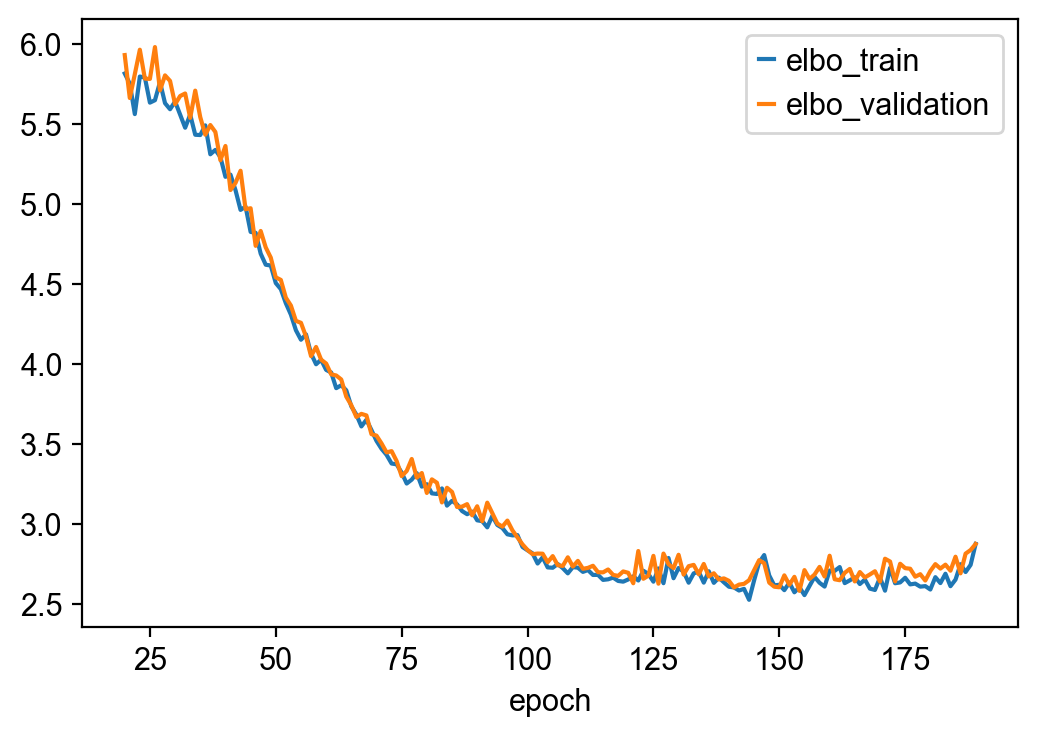

In [200]:
fig, ax = plt.subplots()
reg_vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [201]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(2910.2656, grad_fn=<AddBackward0>)

In [202]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [203]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


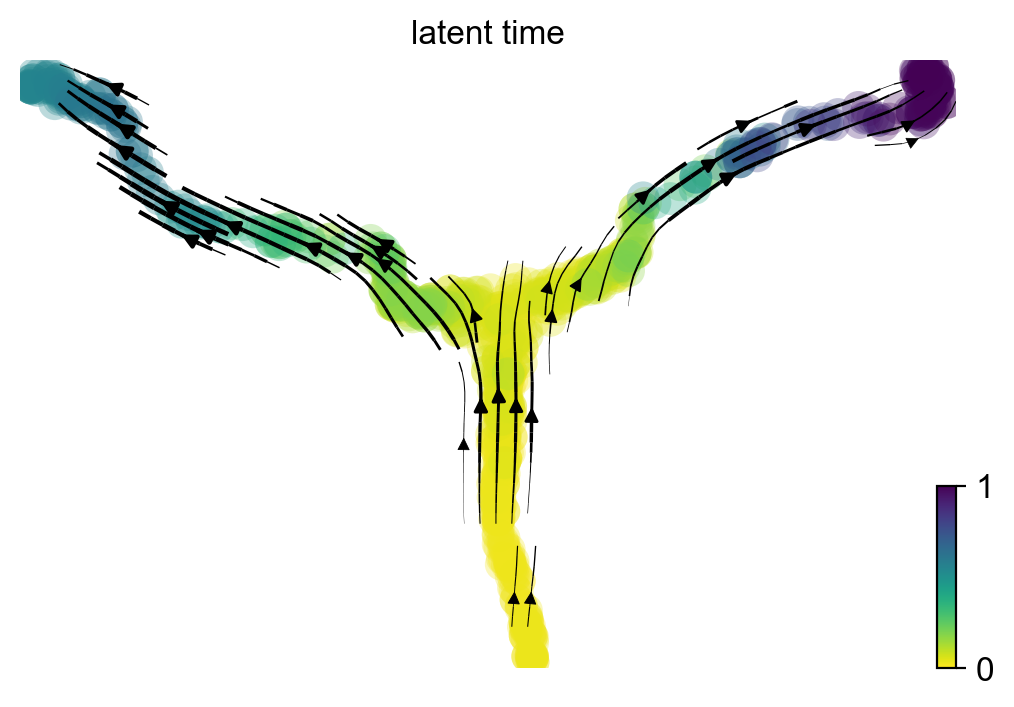

In [204]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [205]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.9053005901890632, pvalue=0.0)

In [206]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:117,117:(117*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [207]:
adata_target.layers["rna_velocity"].max()

17.252201555972604

In [208]:
corr.mean()

0.14384982597678006

In [209]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [210]:
GRN = W.T * reg_vae.module.v_encoder.grn

In [211]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [212]:
pre = GRN[W.T==1]

In [213]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [214]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [215]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.31740072791863033

## GRNBoost2 Initilization

In [38]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T)

In [39]:
celloracle_m = pd.read_csv("celloracle.csv",index_col = 0)
celloracle_m = np.array(celloracle_m)
celloracle_m.max()

29.10208104265729

In [40]:
GRN = torch.tensor(np.log1p(celloracle_m)) * W.T * torch.sign(reg_vae.module.v_encoder.grn.data)
GRN = GRN.float()
GRN

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.1996,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3880,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [41]:
reg_vae.module.v_encoder.grn.data = GRN
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.1996,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-2.3880,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [42]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [43]:
reg_vae.module.dirichlet_concentration = torch.tensor([0.8,0.1,0.1])

In [44]:
reg_vae.module.dirichlet_concentration

tensor([0.8000, 0.1000, 0.1000])

In [45]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.3215, 0.3100, 0.3579, 0.2337, 0.2787, 0.3628, 0.3426, 0.2759, 0.4508,
        0.3901, 0.4685, 0.4536, 0.4990, 0.4693, 0.2713, 0.4403, 0.3902, 0.2787,
        0.4016, 0.3867, 0.2705, 0.3614, 0.3991, 0.4474, 0.3799, 0.5078, 0.3523,
        0.4113, 0.4586, 0.4373, 0.4071, 0.4013, 0.3116, 0.4225, 0.3958, 0.4511,
        0.4245, 0.4034, 0.4865, 0.4185, 0.3649, 0.4787, 0.4063, 0.4329, 0.4524,
        0.4473, 0.4397, 0.3580, 0.3301, 0.4864, 0.3288, 0.3948, 0.3268, 0.4754,
        0.3931, 0.3852, 0.4927, 0.4320, 0.3845, 0.3423, 0.3859, 0.3484, 0.3812,
        0.3394, 0.4772, 0.4323, 0.2416, 0.2453, 0.1585, 0.4301, 0.5108, 0.4601,
        0.4162, 0.4156, 0.4469, 0.4072, 0.4872, 0.3340, 0.3503, 0.4384, 0.5017,
        0.3624, 0.4524, 0.4103, 0.4935, 0.3461, 0.3078, 0.4621, 0.4959, 0.4121,
        0.4006, 0.2810, 0.3505, 0.3031, 0.2208, 0.2678, 0.4658, 0.2877, 0.4652,
        0.3625, 0.3653, 0.3947, 0.4726, 0.4608, 0.4298, 0.3844, 0.4037, 0.4093,
        0.4717, 0.

In [46]:
reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 207/500:  41%|████████████████████▎                            | 207/500 [03:12<04:33,  1.07it/s, loss=-318, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 2.415. Signaling Trainer to stop.


In [47]:
torch.abs(reg_vae.module.v_encoder.grn).sum()

tensor(555.8853, grad_fn=<SumBackward0>)

In [48]:
reg_vae.history['elbo_validation'].size

207

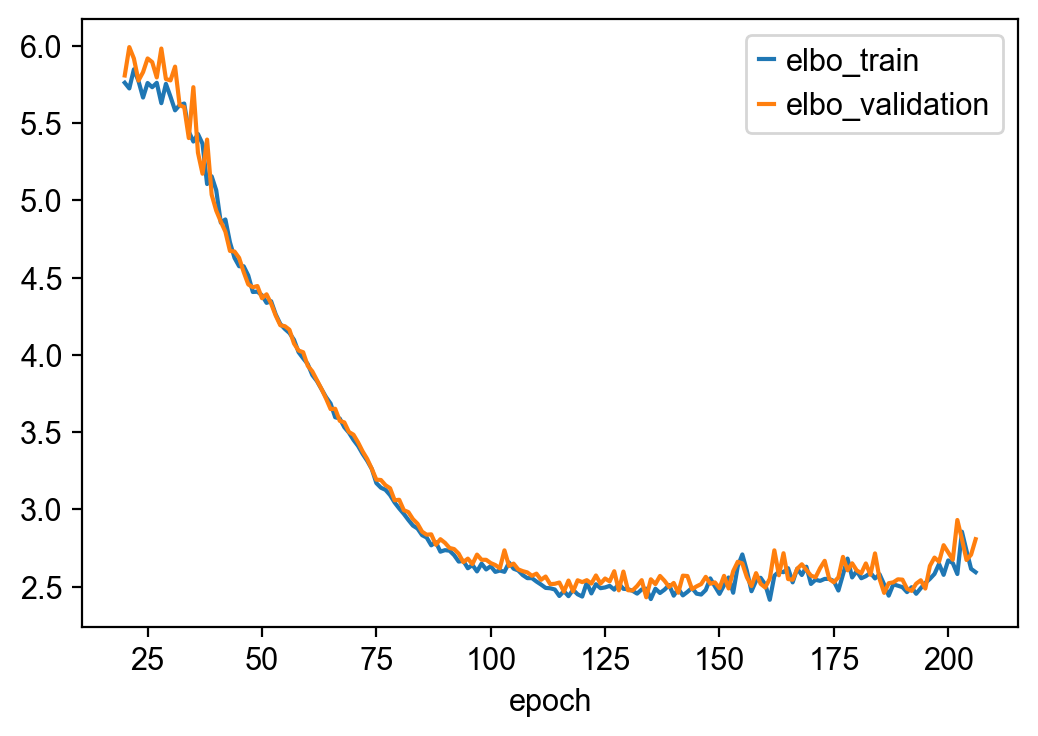

In [49]:
fig, ax = plt.subplots()
reg_vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [50]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(1102.2273, grad_fn=<AddBackward0>)

In [51]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [52]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


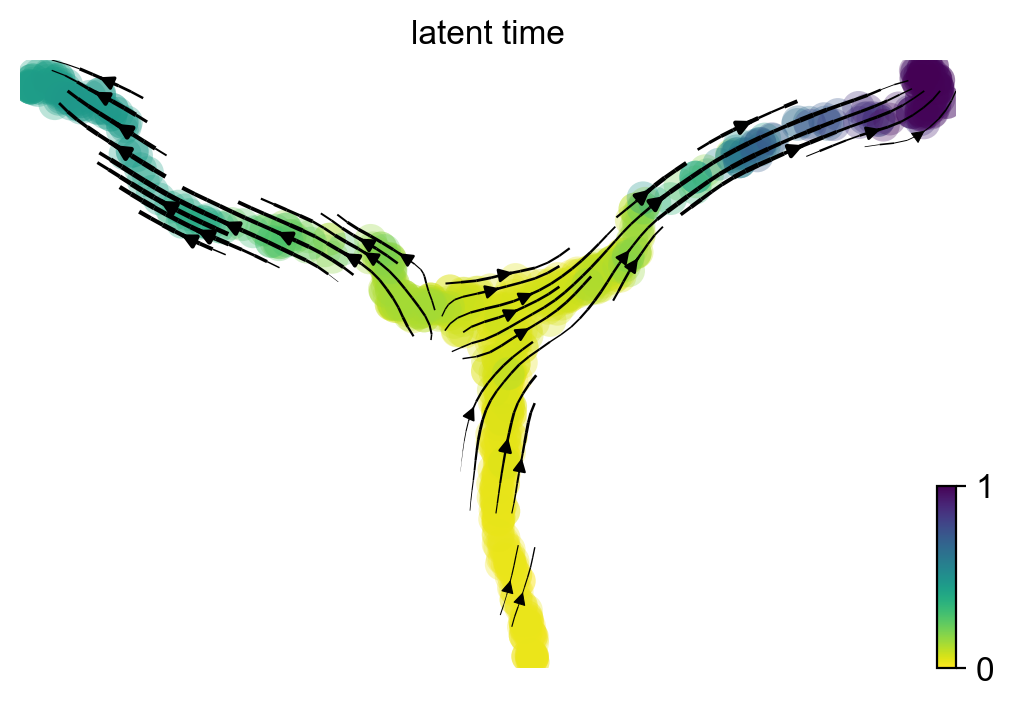

In [53]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [65]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.9151555366346051, pvalue=0.0)

In [66]:
velocity_gt = adata_target.layers["rna_velocity"]
velocity = adata_target.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:117,117:(117*2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

corr = np.array(corr)[:,0]

In [67]:
adata_target.layers["rna_velocity"].max()

17.252201555972604

In [68]:
corr.mean()

0.13763818751375273

In [58]:
velocity_regvelovi = velocity.copy()
corr_regvelovi = corr.copy()

In [59]:
GRN = W.T * reg_vae.module.v_encoder.grn

In [60]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"].T)==1]

In [61]:
pre = GRN[W.T==1]

In [62]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["targets"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
corr_m = corr_m[target_index,]
corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [63]:
pre2 = corr_m[np.array(adata.uns["skeleton"].T)==1]

In [64]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr(np.abs(pre.detach().numpy()),np.abs(gt))
corr

0.5829516068197048

In [169]:
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

In [170]:
GEP = pd.DataFrame(adata.X.todense(),columns = adata.var.index.values)

In [171]:
network = grnboost2(expression_data=GEP,
                    tf_names=adata.uns["regulators"].tolist())

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [172]:
ind = [i in adata.uns["targets"] for i in network["target"]]

In [173]:
network = network[ind]

In [174]:
grnboost_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [175]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (network["TF"] == j) & (network["target"] == i)
        if sum(ind) > 0:
            pdd = network[ind]
            grnboost_m.loc[i,j] = pdd["importance"].values

In [176]:
grnboost_m = np.array(grnboost_m)

In [177]:
grnboost_m.shape

(166, 101)

In [178]:
grn_boost_pre = grnboost_m[np.array(adata.uns["skeleton"]).T==1]

In [179]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [180]:
corr, _ = stats.spearmanr(abs(grn_boost_pre),abs(gt))
corr

-0.0930246246947926

In [217]:
import celloracle as co
co.__version__

'0.12.0'

In [218]:
### generate base_GRN from the ground truth
target_list = []
for i in range(adata.uns["skeleton"].shape[0]):
    a = list(adata.uns["skeleton"].columns[adata.uns["skeleton"].iloc[i,:] == 1])
    a = ','.join(a)
    target_list.append(a)

In [219]:
d = {"TF":adata.uns["skeleton"].index,"Target_genes":target_list}
df = pd.DataFrame(data=d)

In [220]:
TF_to_TG_dictionary = {}

for TF, TGs in zip(df.TF, df.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

  0%|          | 0/117 [00:00<?, ?it/s]

In [221]:
TG_to_TF_dictionary

{'A1_TF1': ['Burn6_TF4'],
 'A5_TF2': ['A4_TF3'],
 'A5_TF3': ['A4_TF3'],
 'A5_TF4': ['A4_TF3'],
 'A6_TF1': ['A4_TF3', 'A5_TF2', 'A5_TF3'],
 'A6_TF2': ['A4_TF3', 'A5_TF3', 'A5_TF4'],
 'A6_TF3': ['A4_TF3', 'A5_TF2', 'A5_TF4'],
 'B10_TF1': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF3'],
 'B10_TF2': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF2'],
 'B10_TF3': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF3'],
 'B11_TF1': ['B2_TF1', 'B2_TF2', 'B8_TF2', 'B8_TF3'],
 'B11_TF2': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF2'],
 'B11_TF3': ['B2_TF1', 'B2_TF2', 'B8_TF1', 'B8_TF3'],
 'B11_TF4': ['B2_TF1', 'B2_TF2', 'B8_TF2', 'B8_TF3'],
 'B12_TF1': ['B3_TF1', 'B3_TF2', 'B8_TF1', 'B8_TF3'],
 'B12_TF2': ['B3_TF1', 'B3_TF2', 'B8_TF1', 'B8_TF3'],
 'B13_TF1': ['B3_TF1', 'B3_TF2', 'B8_TF1', 'B8_TF3'],
 'B13_TF2': ['B3_TF1', 'B3_TF2', 'B8_TF1', 'B8_TF2'],
 'B13_TF3': ['B3_TF1', 'B3_TF2', 'B8_TF2', 'B8_TF3'],
 'B14_TF1': ['B3_TF1', 'B3_TF2', 'B8_TF2', 'B8_TF3'],
 'B14_TF2': ['B3_TF1', 'B3_TF2', 'B8_TF2', 'B8_TF3'],
 'B14_TF3': ['B3_TF1

In [222]:
net = co.Net(gene_expression_matrix=adata.to_df(), # Input gene expression matrix as data frame
             TFinfo_dic=TG_to_TF_dictionary, # Input base GRN
             verbose=True
             )

initiating Net object ...
gem_shape: (1000, 119)
initiation completed.


In [223]:
net.fit_All_genes(bagging_number=20,
                 alpha=10, verbose=True)

  0%|          | 0/117 [00:00<?, ?it/s]

In [224]:
net.updateLinkList(verbose=True)
inference_result = net.linkList.copy()
inference_result

  0%|          | 0/117 [00:00<?, ?it/s]

,source,target,coef_mean,coef_abs,p,-logp
0,Burn6_TF4,A1_TF1,0.041586,0.041586,4.478594e-09,8.348858
1,A4_TF3,A5_TF2,-0.020271,0.020271,9.519369e-09,8.021392
2,A4_TF3,A5_TF3,-0.039356,0.039356,1.283639e-10,9.891557
3,A4_TF3,A5_TF4,-0.030428,0.030428,2.021681e-09,8.694287
4,A5_TF2,A6_TF1,-0.052162,0.052162,6.609359e-07,6.179841
...,...,...,...,...,...,...
310,B7_TF1,Target4,-0.019847,0.019847,2.805606e-02,1.551973
311,B9_TF3,Target5,0.350634,0.350634,1.335012e-26,25.874515
312,B5_TF4,Target6,-0.415237,0.415237,2.401040e-26,25.619601
313,B13_TF3,Target7,0.281043,0.281043,6.539196e-13,12.184476


In [225]:
celloracle_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
celloracle_m = pd.DataFrame(celloracle_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [226]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (inference_result["source"] == j) & (inference_result["target"] == i)
        if sum(ind) > 0:
            pdd = inference_result[ind]
            celloracle_m.loc[i,j] = pdd["-logp"].values

In [227]:
celloracle_m = np.array(celloracle_m)

In [228]:
celloracle_m.shape

(117, 73)

In [229]:
celloracle_pre = celloracle_m[np.array(adata.uns["skeleton"]).T==1]

In [230]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [231]:
corr, _ = stats.spearmanr(np.abs(celloracle_pre),np.abs(gt))
corr

0.3702182742099377

In [826]:
#### using spliced readout to redo the test
adata.X = adata.layers["counts_spliced"].copy()

In [827]:
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
# Log transformation 
sc.pp.log1p(adata)

In [828]:
net = co.Net(gene_expression_matrix=adata.to_df(), # Input gene expression matrix as data frame
             TFinfo_dic=TG_to_TF_dictionary, # Input base GRN
             verbose=True
             )

initiating Net object ...
gem_shape: (1000, 141)
initiation completed.


In [829]:
net.fit_All_genes(bagging_number=20,
                 alpha=10, verbose=True)

  0%|          | 0/133 [00:00<?, ?it/s]

In [830]:
net.updateLinkList(verbose=True)
inference_result = net.linkList.copy()
inference_result

  0%|          | 0/133 [00:00<?, ?it/s]

,source,target,coef_mean,coef_abs,p,-logp
0,A3_TF5,A4_TF1,-1.270633,1.270633,3.898118e-15,14.409145
1,A3_TF3,A4_TF1,-1.341824,1.341824,2.324203e-16,15.633726
2,A3_TF5,A4_TF3,-1.254087,1.254087,5.687045e-16,15.245113
3,A3_TF6,A4_TF3,-1.225692,1.225692,1.783772e-15,14.748661
4,A4_TF3,A5_TF1,-2.188960,2.188960,3.209789e-34,33.493524
...,...,...,...,...,...,...
377,C1_TF5,Target7,-0.171281,0.171281,3.394295e-07,6.469250
378,B8_TF4,Target7,-0.068206,0.068206,7.056627e-06,5.151403
379,C2_TF2,Target8,-1.366446,1.366446,7.063678e-17,16.150969
380,B8_TF4,Target8,-1.843355,1.843355,2.768405e-17,16.557770


In [839]:
celloracle_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
celloracle_m = pd.DataFrame(celloracle_m,index = adata.uns["targets"].tolist(), columns = adata.uns["regulators"].tolist())

In [840]:
for i in adata.uns["targets"]:
    for j in adata.uns["regulators"]:
        ind = (inference_result["source"] == j) & (inference_result["target"] == i)
        if sum(ind) > 0:
            pdd = inference_result[ind]
            celloracle_m.loc[i,j] = pdd["coef_mean"].values

In [841]:
celloracle_m = np.array(celloracle_m)

In [842]:
celloracle_m.shape

(133, 88)

In [843]:
celloracle_pre = celloracle_m[np.array(adata.uns["skeleton"]).T==1]

In [844]:
gt = np.array(adata.uns["network"].T)[np.array(adata.uns["skeleton"]).T==1]

In [845]:
corr, _ = stats.spearmanr(np.abs(celloracle_pre),np.abs(gt))
corr

0.3388070605151547

In [6]:
import pandas as pd
import scvelo as scv
scv.set_figure_params()
d = {'Spearman_Correlation': [0.6038212273157725,
              0.5790204539187273,
              0.3327813100565609, 
              0.48047928408535406,
              0.3388070605151547,
              0.11705164397411455], 
     'Model': ["RegVeloVI(GRNBoost2)","RegVeloVI(CellOracle)","RegVeloVI(Cor)", "GRNBoost2", "CellOracle","Pearsonr(Init)"]}
df = pd.DataFrame(data=d)

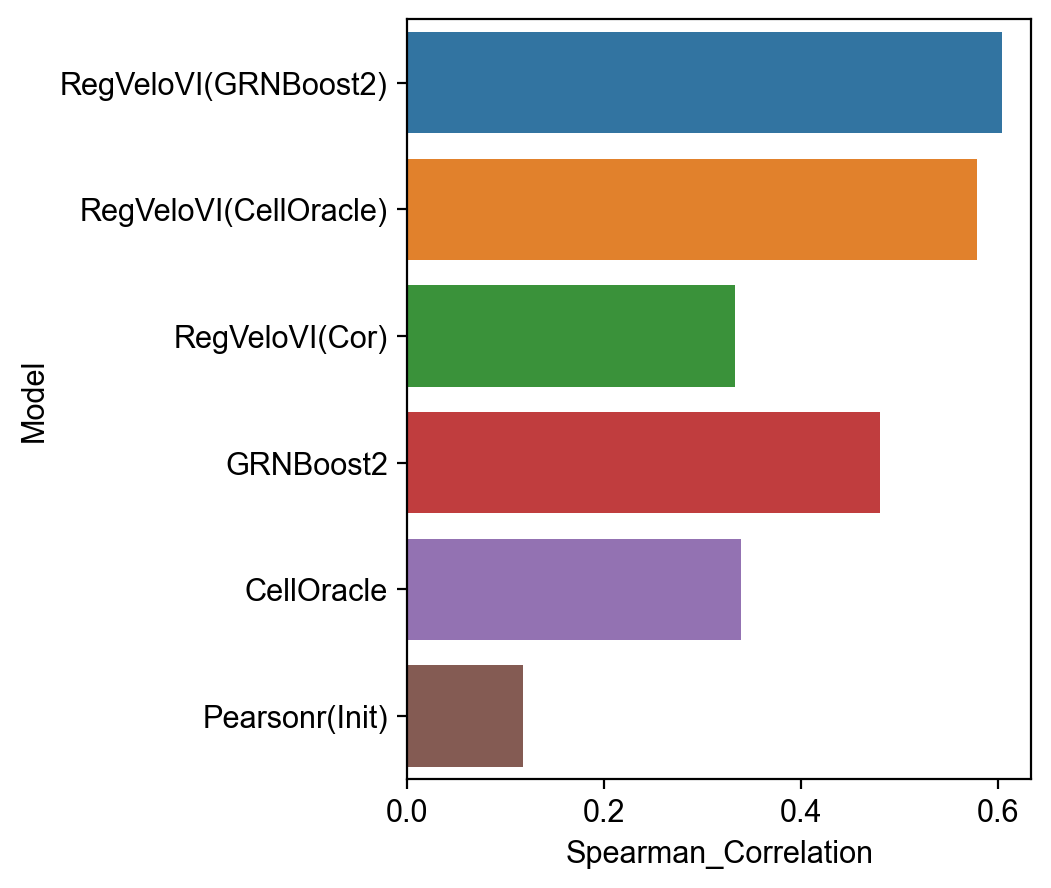

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 5))
ax = sns.barplot(y="Model", x="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [77]:
d = {'Spearman_Correlation': [
              0.9075302190139001,
              0.8757219145990939,
              0.9151555366346051,
              0.9116518924823571], 
     'Model': ["VeloVI","RegVeloVI(Cor)","RegVeloVI(CellOracle)","RegVeloVI(GRNBoost2)"]}
df = pd.DataFrame(data=d)

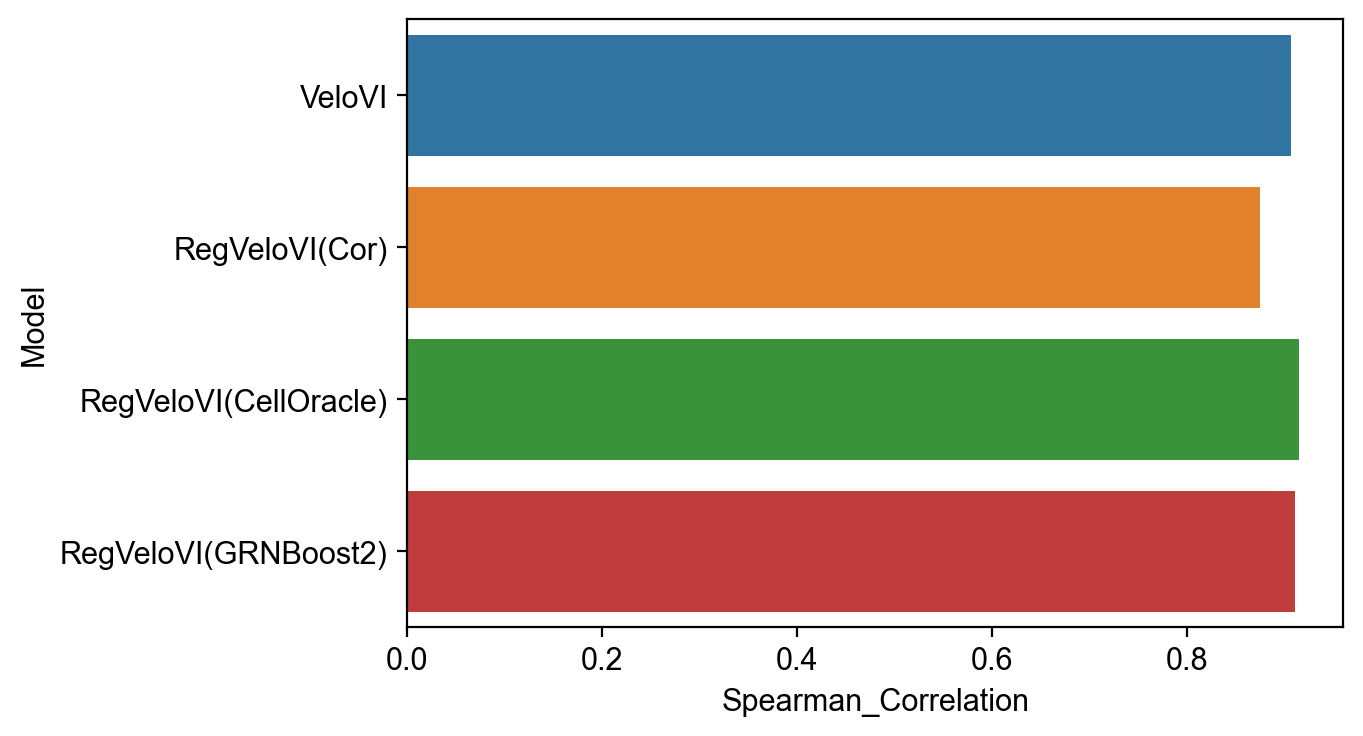

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Spearman_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [74]:
d = {'Mean_Pearson_Correlation': [0.135,
              0.13763818751375273,
              0.144], 
     'Model': ["RegVeloVI(Cor)","RegVeloVI(CellOracle)","RegVeloVI(GRNBoost2)"]}
df = pd.DataFrame(data=d)

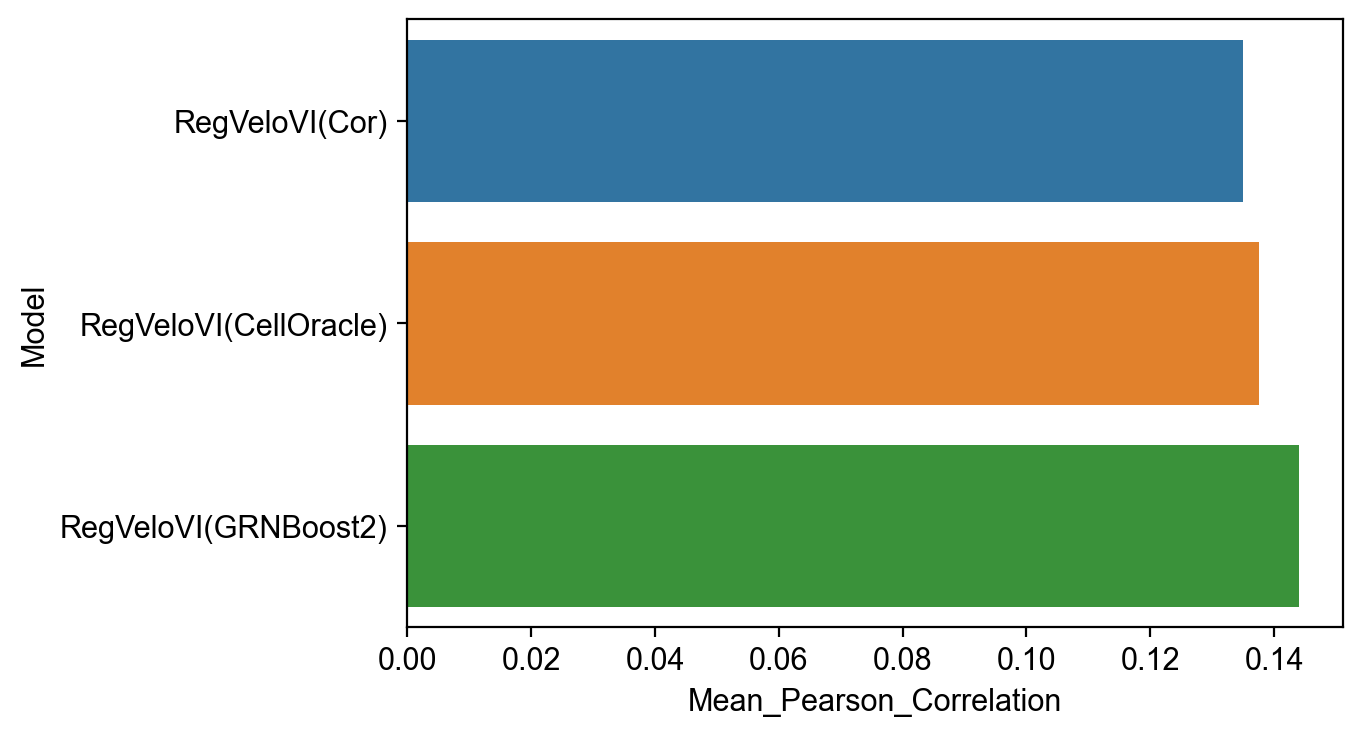

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="Mean_Pearson_Correlation", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [90]:
import logging
import warnings
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union
from anndata import AnnData
import torch.nn.functional as F

def get_pred_readout(
    self,
    adata: Optional[AnnData] = None,
    indices: Optional[Sequence[int]] = None,
    gene_list: Optional[Sequence[str]] = None,
    n_samples: int = 1,
    n_samples_overall: Optional[int] = None,
    batch_size: Optional[int] = None,
    return_mean: bool = True,
    return_numpy: Optional[bool] = None,
    velo_statistic: str = "mean",
    velo_mode: Literal["spliced", "unspliced"] = "spliced",
    clip: bool = True,
) -> Union[np.ndarray, pd.DataFrame]:
    """Returns cells by genes velocity estimates.

    Parameters
    ----------
    adata
        AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
        AnnData object used to initialize the model.
    indices
        Indices of cells in adata to use. If `None`, all cells are used.
    gene_list
        Return velocities for a subset of genes.
        This can save memory when working with large datasets and few genes are
        of interest.
    n_samples
        Number of posterior samples to use for estimation for each cell.
    n_samples_overall
        Number of overall samples to return. Setting this forces n_samples=1.
    batch_size
        Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
    return_mean
        Whether to return the mean of the samples.
    return_numpy
        Return a :class:`~numpy.ndarray` instead of a :class:`~pandas.DataFrame`. DataFrame includes
        gene names as columns. If either `n_samples=1` or `return_mean=True`, defaults to `False`.
        Otherwise, it defaults to `True`.
    velo_statistic
        Whether to compute expected velocity over states, or maximum a posteriori velocity over maximal
        probability state.
    velo_mode
        Compute ds/dt or du/dt.
    clip
        Clip to minus spliced value

    Returns
    -------
    If `n_samples` > 1 and `return_mean` is False, then the shape is `(samples, cells, genes)`.
    Otherwise, shape is `(cells, genes)`. In this case, return type is :class:`~pandas.DataFrame` unless `return_numpy` is True.
    """
    adata = self._validate_anndata(adata)
    if indices is None:
        indices = np.arange(adata.n_obs)
    if n_samples_overall is not None:
        indices = np.random.choice(indices, n_samples_overall)
        n_samples = 1
    scdl = self._make_data_loader(
        adata=adata, indices=indices, batch_size=batch_size
    )

    if gene_list is None:
        gene_mask = slice(None)
    else:
        all_genes = adata.var_names
        gene_mask = [True if gene in gene_list else False for gene in all_genes]

    if n_samples > 1 and return_mean is False:
        if return_numpy is False:
            warnings.warn(
                "return_numpy must be True if n_samples > 1 and return_mean is False, returning np.ndarray"
            )
        return_numpy = True
    if indices is None:
        indices = np.arange(adata.n_obs)

    pre_u_all = []
    pre_s_all = []
    for tensors in scdl:
        minibatch_samples_u = []
        minibatch_samples_s = []
        for _ in range(n_samples):
            inference_outputs, generative_outputs = self.module.forward(
                tensors=tensors,
                compute_loss=False,
            )
            pi = generative_outputs["px_pi"]
            beta = inference_outputs["beta"]
            gamma = inference_outputs["gamma"]
            tau = generative_outputs["px_tau"]
            rho = generative_outputs["px_rho"]

            ind_prob = pi[..., 0]
            #steady_prob = pi[..., 1]
            rep_prob = pi[..., 1]
            switch_time = F.softplus(self.module.switch_time_unconstr)

            ind_time = switch_time * rho
            u_0, s_0 = self.module._get_induction_unspliced_spliced(
                switch_time.reshape(1,len(switch_time))
            )
            rep_time = (self.module.t_max - switch_time) * tau
            mean_u_rep, mean_s_rep = self.module._get_repression_unspliced_spliced(
                u_0,
                s_0,
                beta,
                gamma,
                rep_time,
            )

            mean_u_ind, mean_s_ind = self.module._get_induction_unspliced_spliced(
                ind_time
            )

            # expectation
            pre_u = (
                ind_prob * mean_u_ind
                + rep_prob * mean_u_rep
            )

            pre_s = (
                ind_prob * mean_s_ind
                + rep_prob * mean_s_rep
            )

            pre_u = pre_u[..., gene_mask]
            pre_u = pre_u.detach().cpu().numpy()
            pre_s = pre_s[..., gene_mask]
            pre_s = pre_s.detach().cpu().numpy()

            minibatch_samples_u.append(pre_u)
            minibatch_samples_s.append(pre_s)
        # samples by cells by genes
        pre_u_all.append(np.stack(minibatch_samples_u, axis=0))
        pre_s_all.append(np.stack(minibatch_samples_s, axis=0))
        if return_mean:
            # mean over samples axis
            pre_u_all[-1] = np.mean(pre_u_all[-1], axis=0)
            pre_s_all[-1] = np.mean(pre_s_all[-1], axis=0)

    if n_samples > 1:
        # The -2 axis correspond to cells.
        pre_u_all = np.concatenate(pre_u_all, axis=-2)
        pre_s_all = np.concatenate(pre_s_all, axis=-2)
    else:
        pre_u_all = np.concatenate(pre_u_all, axis=0)
        pre_s_all = np.concatenate(pre_s_all, axis=0)

    if return_numpy is None or return_numpy is False:
        pre_u_all = pd.DataFrame(
            pre_u_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        pre_s_all = pd.DataFrame(
            pre_s_all,
            columns=adata.var_names[self.module.target_index],
            index=adata.obs_names[indices],
        )
        return pre_u_all, pre_s_all
    else:
        return pre_u_all, pre_s_all

In [91]:
pre_u, pre_s = get_pred_readout(reg_vae,n_samples=25, velo_statistic="mean")

In [92]:
### running model with different prior state setting
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae2 = REGVELOVI(adata,W=W.T)
reg_vae2.module.dirichlet_concentration = torch.tensor([0.6,0.2,0.2])

In [93]:
reg_vae2.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 173/500:  35%|████████████████▉                                | 173/500 [03:32<06:41,  1.23s/it, loss=-757, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 5.292. Signaling Trainer to stop.


In [94]:
pre_u2, pre_s2 = get_pred_readout(reg_vae2,n_samples=25, velo_statistic="mean")

In [95]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae3 = REGVELOVI(adata,W=W.T)
reg_vae3.module.dirichlet_concentration = torch.tensor([0.5,0.25,0.25])

In [96]:
reg_vae3.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 160/500:  32%|███████████████▋                                 | 160/500 [03:17<07:00,  1.24s/it, loss=-751, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 5.467. Signaling Trainer to stop.


In [97]:
pre_u3, pre_s3 = get_pred_readout(reg_vae3,n_samples=25, velo_statistic="mean")

In [98]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae4 = REGVELOVI(adata,W=W.T)
reg_vae4.module.dirichlet_concentration = torch.tensor([1,0.001,0.001])

In [99]:
reg_vae4.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 49/500:  10%|████▉                                              | 49/500 [00:56<08:40,  1.15s/it, loss=-203, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 11.574. Signaling Trainer to stop.


In [100]:
pre_u4, pre_s4 = get_pred_readout(reg_vae4,n_samples=25, velo_statistic="mean")

In [101]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae5 = REGVELOVI(adata,W=W.T)
reg_vae5.module.dirichlet_concentration = torch.tensor([1/3,1/3,1/3])

In [102]:
reg_vae5.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 190/500:  38%|██████████████████▌                              | 190/500 [03:59<06:30,  1.26s/it, loss=-801, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 3.818. Signaling Trainer to stop.


In [103]:
pre_u5, pre_s5 = get_pred_readout(reg_vae5,n_samples=25, velo_statistic="mean")

In [104]:
import sklearn
rmse_s4 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s4))
rmse_u4 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u4))
rmse_s3 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s3))
rmse_u3 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u3))
rmse_s2 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s2))
rmse_u2 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u2))
rmse_s = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s))
rmse_u = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u))

In [105]:
rmse_s5 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Ms"][:,reg_vae.module.target_index],pre_s5))
rmse_u5 = np.sqrt(sklearn.metrics.mean_squared_error(adata.layers["Mu"][:,reg_vae.module.target_index],pre_u5))

In [90]:
(rmse_s3+rmse_u3)/2

0.08017212152481079

In [92]:
(rmse_s2+rmse_u2)/2

0.07588041573762894

In [91]:
(rmse_s+rmse_u)/2

0.07334978878498077

In [81]:
(rmse_s4+rmse_u4)/2

0.08535401523113251

In [104]:
(rmse_s5+rmse_u5)/2

0.0852842852473259

In [106]:
d = {'RMSE': [(rmse_s5+rmse_u5)/2, 
              (rmse_s3+rmse_u3)/2,
              (rmse_s2+rmse_u2)/2,
              (rmse_s+rmse_u)/2,
              (rmse_s4+rmse_u4)/2], 
     'Model': ["concentration: 0.3333:0.3333:0.3333", "concentration: 0.5:0.25:0.25", "concentration: 0.6:0.2:0.2", "concentration: 0.8:0.1:0.1", "concentration:1:1.001:1.001"]}
df = pd.DataFrame(data=d)

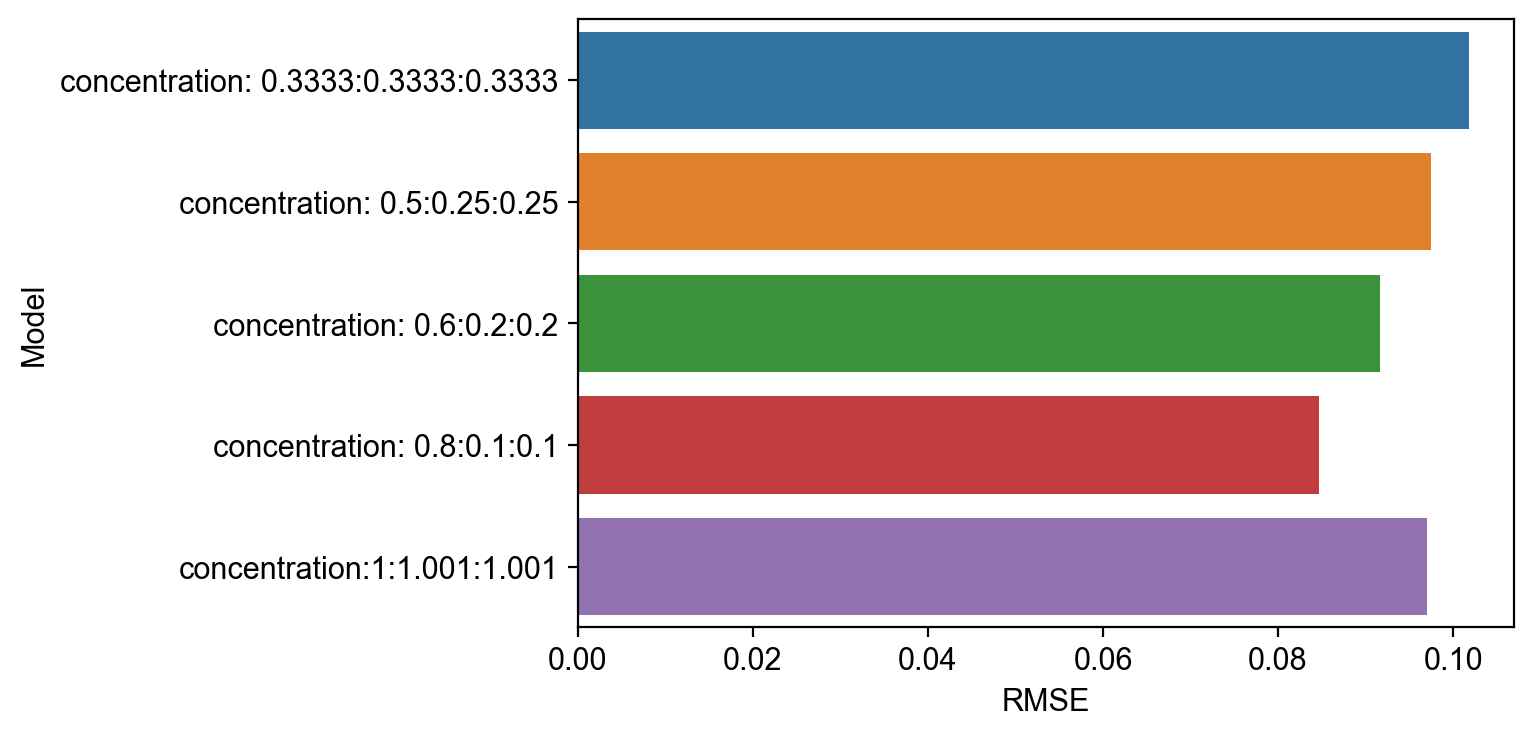

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(y="Model", x="RMSE", data=df)  # RUN PLOT   
plt.show()

plt.clf()
plt.close()

In [76]:
## Compare the model with VeloVI reconstruction

## test on cell cycling dataset

In [1]:
from regvelovi import REGVELOVI

Global seed set to 0
/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import sctour as rgv
from velovi import preprocess_data

In [3]:
scv.set_figure_params()

In [4]:
adata = sc.read_h5ad("dataset_cycle.h5ad")

In [5]:
def sanity_check(adata):
    reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
    tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
    adata.uns["regulators"] = adata.uns["regulators"][reg_index]
    adata.uns["targets"] = adata.uns["targets"][tar_index]
    W = adata.uns["skeleton"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["skeleton"] = W
    W = adata.uns["network"]
    W = W[reg_index,:]
    W = W[:,tar_index]
    adata.uns["network"] = W
    
    regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
    targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]
    
    adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()
    
    ## to make sure consistency
    regulator_index = [i in regulators for i in adata.var.index.values]
    target_index = [i in targets for i in adata.var.index.values]
    regulators = adata.var.index.values[regulator_index]
    targets = adata.var.index.values[target_index]
    print("num regulators: "+str(len(regulators)))
    print("num targets: "+str(len(targets)))
    
    W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["skeleton"] = W
    W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
    W = W.loc[regulators,targets]
    adata.uns["network"] = W
    
    adata.uns["regulators"] = regulators
    adata.uns["targets"] = targets
    
    return adata

In [6]:
adata.uns["skeleton"].shape

(260, 260)

In [7]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=260)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 43 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
adata.layers["Ms"].max()

25811.777

In [10]:
adata.X = np.log1p(adata.X.copy())

In [11]:
adata = preprocess_data(adata)
adata = sanity_check(adata)
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 101
num targets: 166


In [13]:
import torch
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [46]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata,W=W.T)

In [47]:
GRN = torch.tensor(np.log1p(np.abs(np.array(adata.uns["network"].T)))) * W.T * torch.sign(torch.tensor(np.log1p(np.array(adata.uns["network"].T))))
GRN = GRN.float()
GRN

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [48]:
GRN.max()

tensor(4.5478)

In [49]:
reg_vae.module.v_encoder.grn.data = GRN
reg_vae.module.v_encoder.grn

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [50]:
reg_vae.module.alpha_1_unconstr

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [51]:
GRN.max()

tensor(4.5478)

In [52]:
reg_vae.module.dirichlet_concentration = torch.tensor([1/3,1/3,1/3])

In [53]:
reg_vae.module.dirichlet_concentration

tensor([0.3333, 0.3333, 0.3333])

In [54]:
reg_vae.module.v_encoder.alpha_unconstr_bias

Parameter containing:
tensor([0.4896, 0.3679, 0.5007, 0.4795, 0.4850, 0.5121, 0.4836, 0.4756, 0.4960,
        0.4214, 0.4664, 0.4432, 0.4760, 0.4511, 0.4237, 0.4659, 0.5138, 0.4977,
        0.5015, 0.3979, 0.4769, 0.4852, 0.4735, 0.4899, 0.4651, 0.4691, 0.4944,
        0.4434, 0.4859, 0.4590, 0.5035, 0.4959, 0.4971, 0.4464, 0.4875, 0.4171,
        0.4610, 0.4420, 0.3746, 0.4058, 0.4761, 0.4162, 0.4313, 0.5125, 0.4391,
        0.4927, 0.3841, 0.3792, 0.4205, 0.4532, 0.5073, 0.4150, 0.4766, 0.5081,
        0.4942, 0.4821, 0.5260, 0.3590, 0.4926, 0.4355, 0.4915, 0.4741, 0.4298,
        0.3965, 0.4907, 0.2728, 0.4328, 0.4326, 0.4452, 0.4344, 0.5199, 0.4331,
        0.4819, 0.4432, 0.4386, 0.4677, 0.4997, 0.4669, 0.4289, 0.4675, 0.4578,
        0.4927, 0.5219, 0.4785, 0.5126, 0.5050, 0.5291, 0.5061, 0.4465, 0.4891,
        0.4844, 0.5038, 0.3912, 0.4892, 0.4547, 0.4426, 0.4422, 0.3735, 0.4311,
        0.4783, 0.5030, 0.4473, 0.5011, 0.4137, 0.4790, 0.5119, 0.4693, 0.4913,
        0.4697, 0.

In [55]:
reg_vae.train(max_epochs=500,lr=0.01,optimizer = "AdamW",weight_decay = 1e-5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 243/500:  49%|███████████████████████▊                         | 243/500 [04:00<04:14,  1.01it/s, loss=-544, v_num=1]
Monitored metric elbo_train did not improve in the last 45 records. Best score: 6.019. Signaling Trainer to stop.


In [56]:
torch.abs(reg_vae.module.v_encoder.grn).sum()

tensor(288.4075, grad_fn=<SumBackward0>)

In [57]:
reg_vae.history['elbo_validation'].size

243

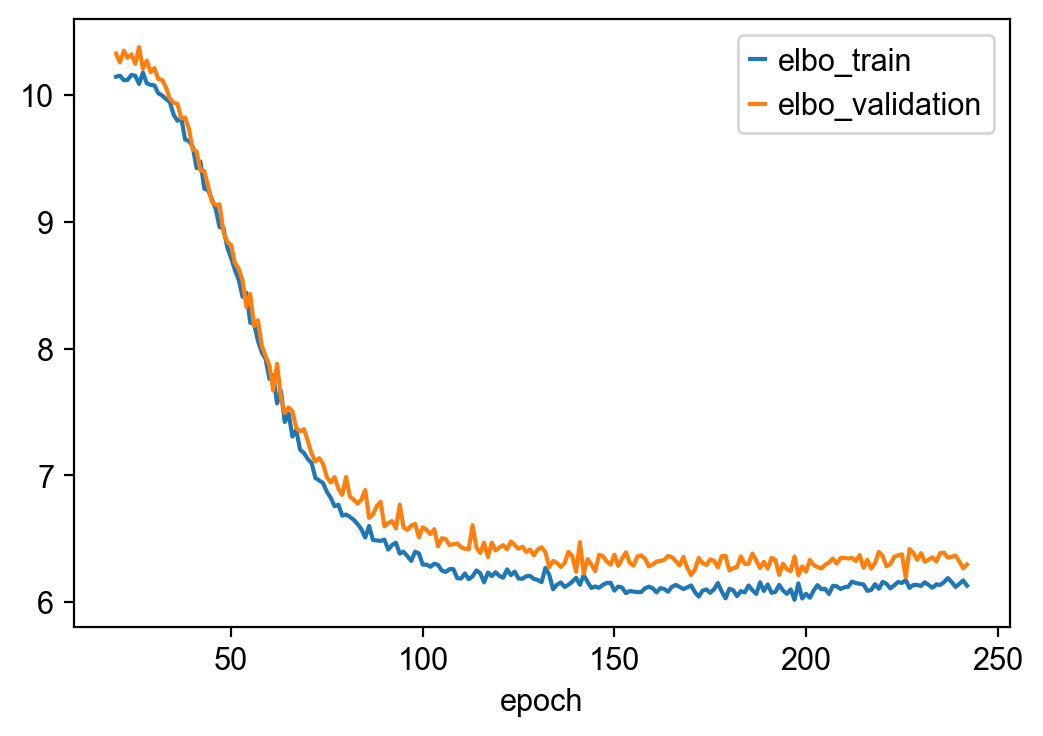

In [58]:
fig, ax = plt.subplots()
reg_vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_train")
reg_vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="reconstruction_emulator_validation")
plt.legend()

In [59]:
sum(p.pow(2.0).sum() for p in reg_vae.module.v_encoder.grn)

tensor(447.8962, grad_fn=<AddBackward0>)

In [60]:
def add_velovi_outputs_to_adata(adata_raw, vae):
    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    #adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    #adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    #adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

adata_target = add_velovi_outputs_to_adata(adata, reg_vae)

In [61]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/8 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


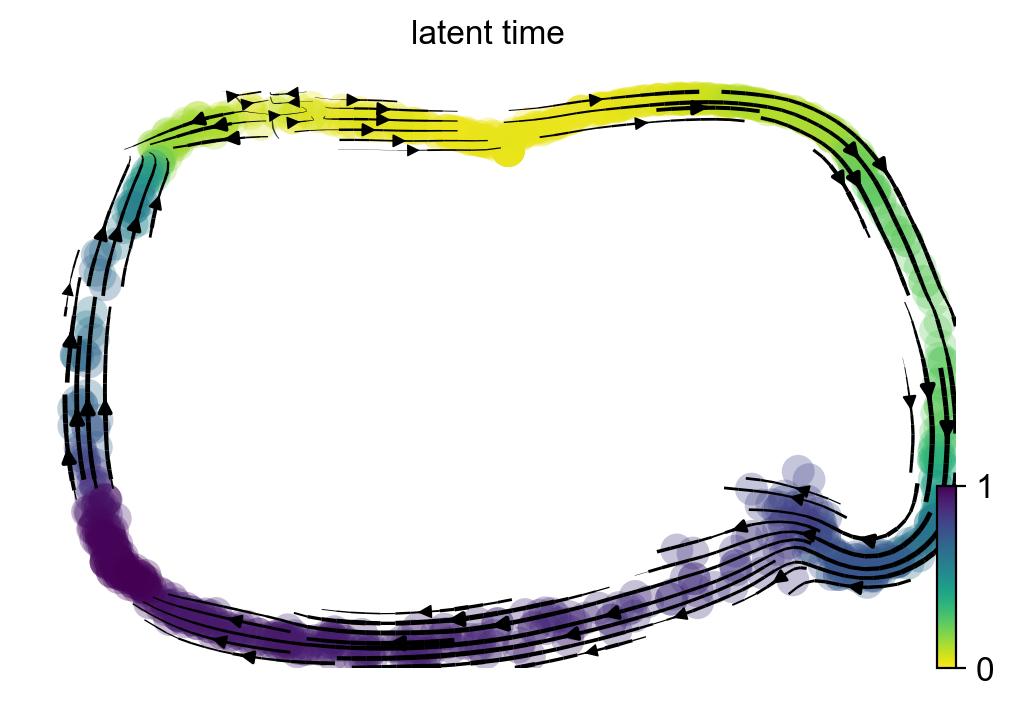

In [62]:
scv.tl.latent_time(adata_target,min_likelihood=None)
scv.pl.velocity_embedding_stream(adata_target, basis='dimred',color = 'latent_time')

In [63]:
import scipy
scipy.stats.spearmanr(adata_target.obs["latent_time"], adata_target.obs["sim_time"])

SignificanceResult(statistic=0.2644632298548045, pvalue=1.82428035207353e-17)